In [42]:
# for questions, please refer to Daniel Gruen & Oliver Friedrich
import os 
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from scipy.stats import chi2
%matplotlib inline 

In [3]:
# generate data

# make reproducible
np.random.seed(5)

theta_min = 2.5
theta_max = 250.0
N_theta   = 20
theta_edges = np.geomspace(theta_min, theta_max, N_theta+1)
thetas = np.sqrt(theta_edges[1:]*theta_edges[:-1])

# true parameters of model
A_true = 2.0
B_true = 2.0
alpha_B_true = 0.3

# model for the mean of the data vector
xi_mean = A_true*thetas**0.5 + B_true*thetas**alpha_B_true

# adding (a fairly small amount!) of noise and storing in a covariance/precision matrix
sigma=1.0
errors = np.ones(N_theta)*sigma
covariance = np.diag(errors**2)
precision_matrix = np.linalg.inv(covariance)
xi_obs = np.random.multivariate_normal(xi_mean, covariance)

# this is also the file the students got in the cloud folder
# note we did not release the "true" parameter values! you should reveal that in the tutorial
np.savetxt("xi_measurement.dat", np.transpose([thetas, xi_obs, errors]), header="theta[arcmin]  xi_+(theta)  sigma(xi_+(theta))")

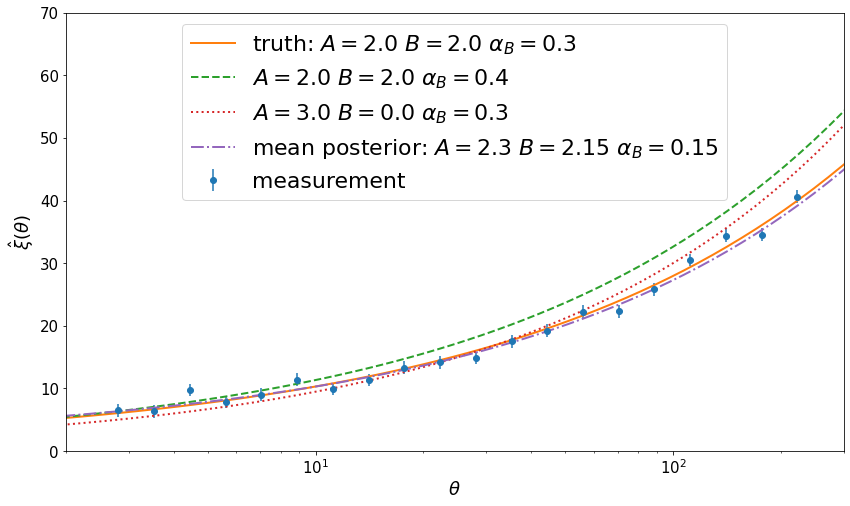

In [9]:
# making a plot of the data with some models on it

plt.figure(figsize=(12,7))
plt.errorbar(thetas, xi_obs, errors, fmt='o', label='measurement')
plt.xlim(2, 300)
plt.ylim(0, 70)
theta_fine = np.geomspace(0.1, 1000, 100)
A = A_true
alpha_B = alpha_B_true
B = B_true
plt.plot(theta_fine, A*theta_fine**0.5 + B*theta_fine**alpha_B, label=r'truth: $A=$'+str(A)+r' $B=$'+str(B)+r' $\alpha_B=$'+str(alpha_B), linewidth=2, linestyle='solid')
A = A_true
alpha_B = alpha_B_true+0.1
B = B_true
plt.plot(theta_fine, A*theta_fine**0.5 + B*theta_fine**alpha_B, label=r'$A=$'+str(A)+r' $B=$'+str(B)+r' $\alpha_B=$'+str(alpha_B), linewidth=2, linestyle='dashed')
A = A_true+B_true/2
alpha_B = alpha_B_true
B = 0.0
plt.plot(theta_fine, A*theta_fine**0.5 + B*theta_fine**alpha_B, label=r'$A=$'+str(A)+r' $B=$'+str(B)+r' $\alpha_B=$'+str(alpha_B), linewidth=2, linestyle='dotted')


A = 2.3
B = 2.15
alpha_B = 0.15
plt.plot(theta_fine, A*theta_fine**0.5 + B*theta_fine**alpha_B, label=r'mean posterior: $A=$'+str(A)+r' $B=$'+str(B)+r' $\alpha_B=$'+str(alpha_B), linewidth=2, linestyle='-.')


plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\theta$', size=18)
plt.ylabel(r'$\hat\xi(\theta)$', size=18)
plt.legend(fontsize=22, loc='upper center')
dummy = plt.xticks(size=15)
dummy = plt.yticks(size=15)
plt.subplots_adjust(left=0.08, right=0.98, bottom=0.1, top=0.97)
plt.savefig("xi_measurement.pdf")

In [43]:
# defining functions the sampler will need

def log_likelihood(theta, x, y, precision_matrix):
    A, B, alpha_B = theta
    model = A * x**0.5 + B * x**alpha_B
    residual = y - model
    chiSq = np.linalg.multi_dot([residual, precision_matrix, residual])
    return -0.5*chiSq

def log_prior(theta):
    A, B, alpha_B = theta
    # this is the prior given in the problem set
    if alpha_B >=0 and abs(alpha_B) <= 1 and A >= -10 and A <= 10 and B <= 10 and B >= -10:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [44]:
import emcee

pos = np.array((A_true, B_true, alpha_B)) + 0.01 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(thetas, xi_obs, precision_matrix)
)
_=sampler.run_mcmc(pos, 20000, progress=True) 
# 5000 steps (as used in the tutorial) is a bit short!

100%|██████████| 20000/20000 [00:23<00:00, 864.98it/s]


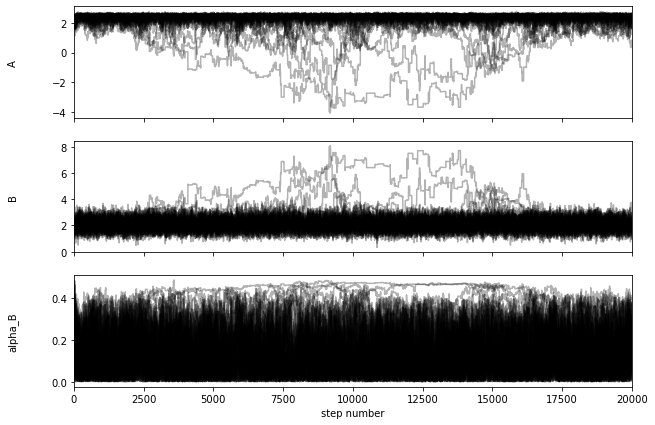

In [45]:
# plot chains, as in the tutorial
# the extended excursions to very low A are a sign that this is a fairly degenerate likelihood

ndim=3
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "B", "alpha_B"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [46]:
# this will return an error if the chain is too short (as it is if you make only 5000 steps)
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [756.51185103 550.73934389 562.11202564]

In [47]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True) 
# need >1x autocorrelation discarded as burn-in
print(flat_samples.shape)

(41600, 3)


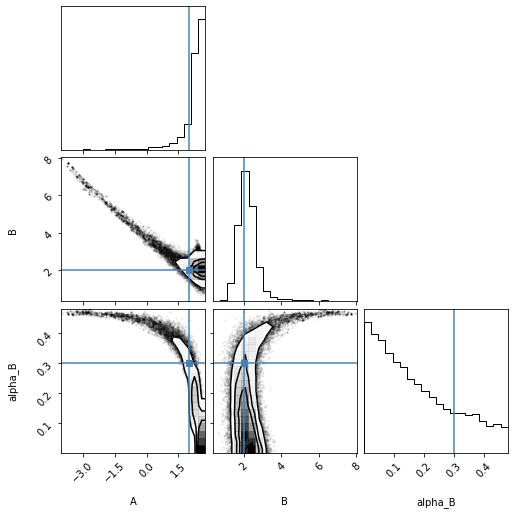

In [48]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[A_true, B_true, alpha_B_true]
)

In [49]:
np.mean(flat_samples,axis=0)

array([2.10729355, 2.25991115, 0.171814  ])

In [18]:
np.std(flat_samples,axis=0)

array([0.32203094, 0.40885202, 0.11121985])

In [94]:
print(A_true, B_true, alpha_B_true)

2.0 2.0 0.3


In [50]:
# covariance method

Bsample = np.random.uniform(-10, 10, 10000)
alpha_B_sample = np.random.uniform(0,0.4,10000)
nuisance_sample = Bsample*np.power.outer(thetas,alpha_B_sample)

In [51]:
M = np.cov(nuisance_sample)

In [52]:
precision_matrix_nuisance = np.linalg.inv(M+covariance)

In [53]:
# defining functions the sampler will need

def log_likelihood(theta, x, y, precision_matrix):
    A = theta[0]
    model = A * x**0.5 
    residual = y - model
    chiSq = np.linalg.multi_dot([residual, precision_matrix, residual])
    return -0.5*chiSq

def log_prior(theta):
    A = theta[0]
    # this is the prior given in the problem set, on A only
    if A >= -10 and A <= 10 :
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [54]:
pos = np.array((A_true)) + 0.01 * np.random.randn(32, 1)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(thetas, xi_obs, precision_matrix_nuisance)
)
_=sampler.run_mcmc(pos, 20000, progress=True) 
# 5000 steps (as used in the tutorial) is a bit short!

100%|██████████| 20000/20000 [00:19<00:00, 1051.11it/s]


In [55]:
# this will return an error if the chain is too short
tau = sampler.get_autocorr_time()
print(tau)

[27.3895969]


In [56]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True) 
# need >1x autocorrelation discarded as burn-in
print(flat_samples.shape)

(41600, 1)


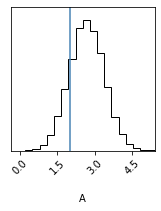

In [57]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[A_true]
)

In [58]:
np.mean(flat_samples,axis=0),np.std(flat_samples,axis=0)

(array([2.67680152]), array([0.69386614]))

In [ ]:
# This is obviously off as well (A_true is 2.0) 
# - that the nuisance is a multivariate Gaussian in the data is a false assumption

In [41]:
# bonus exercise - no solution provided :)